In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
#         print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import sys
import torch
import subprocess
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
    version_str="".join([
        f"py3{sys.version_info.minor}_cu",
        torch.version.cuda.replace(".",""),
        f"_pyt{pyt_version_str}"
    ])
    !pip install iopath
    if sys.platform.startswith("linux"):
        print("Trying to install wheel for PyTorch3D")
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
        pip_list = !pip freeze
        need_pytorch3d = not any(i.startswith("pytorch3d==") for  i in pip_list)
    if need_pytorch3d:
        print(f"failed to find/install wheel for {version_str}")
if need_pytorch3d:
    print("Installing PyTorch3D from source")
    !pip install ninja
    !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31532 sha256=49ec48b607679a9be99e3200196a0e2b33795e3258dc408e9960b14af878fffb
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built iopath
Trying to install wheel for PyTorch3D
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu123_pyt240/download.html
ERROR: Could not find a version that satisfies the requirement pytorch3d (from versions: none)
ERROR: No matching distribution found for pytorch3d
failed to find/install wheel for py310_cu123_pyt240
Installing PyTorch3D from source
  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-5nwd34ph
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorch3d.git

In [28]:
# We also install chumpy as it is needed to load the SMPL model pickle file.
!pip install chumpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chumpy: filename=chumpy-0.70-py3-none-any.whl size=58263 sha256=3fbac4ac772c9d1ae1a08727ff963cff2c6cf651c6fa2cf6af5032486952e6d2
  Stored in directory: /root/.cache/pip/wheels/e0/c1/ef/29ba7be03653a29ef6f2c3e1956d6c4d8877f2b243af411db1
Successfully built chumpy


In [7]:
import os
import torch
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
import numpy as np
from tqdm.notebook import tqdm
%matplotlib notebook 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

# Set the device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

In [29]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np

# libraries for reading data from files
from scipy.io import loadmat
from PIL import Image
import pickle

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

In [2]:
trg_obj = '/kaggle/input/pix3d-dataset/model/bed/IKEA_BEDDINGE/model.obj'

In [30]:
# Texture image
!wget -P data/DensePose https://raw.githubusercontent.com/facebookresearch/DensePose/master/DensePoseData/demo_data/texture_from_SURREAL.png

# UV_processed.mat
!wget https://dl.fbaipublicfiles.com/densepose/densepose_uv_data.tar.gz
!tar xvf densepose_uv_data.tar.gz -C data/DensePose
!rm densepose_uv_data.tar.gz

--2024-10-02 12:43:29--  https://raw.githubusercontent.com/facebookresearch/DensePose/master/DensePoseData/demo_data/texture_from_SURREAL.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 831242 (812K) [image/png]
Saving to: 'data/DensePose/texture_from_SURREAL.png'

texture_from_SURREA 100%[===================>] 811.76K  --.-KB/s    in 0.06s   

2024-10-02 12:43:29 (13.2 MB/s) - 'data/DensePose/texture_from_SURREAL.png' saved [831242/831242]

--2024-10-02 12:43:30--  https://dl.fbaipublicfiles.com/densepose/densepose_uv_data.tar.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.238.176.126, 18.238.176.44, 18.238.176.19, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.238.176.126|:443... connected.
HTTP request sent, a

In [41]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")
    
# Set paths
DATA_DIR = "/kaggle/working/data"
data_filename = os.path.join(DATA_DIR, "DensePose/UV_Processed.mat")
tex_filename = os.path.join(DATA_DIR,"DensePose/texture_from_SURREAL.png")
# rename your .pkl file or change this string
verts_filename = '/kaggle/input/basemodel/basicmodel_m_lbs_10_207_0_v1.0.0.pkl'


# Load SMPL and texture data
with open(verts_filename, 'rb') as f:
    data = pickle.load(f, encoding='latin1') 
    v_template = torch.Tensor(data['v_template']).to(device) # (6890, 3)
ALP_UV = loadmat(data_filename)
with Image.open(tex_filename) as image:
    np_image = np.asarray(image.convert("RGB")).astype(np.float32)
tex = torch.from_numpy(np_image / 255.)[None].to(device)

verts = torch.from_numpy((ALP_UV["All_vertices"]).astype(int)).squeeze().to(device) # (7829,)
U = torch.Tensor(ALP_UV['All_U_norm']).to(device) # (7829, 1)
V = torch.Tensor(ALP_UV['All_V_norm']).to(device) # (7829, 1)
faces = torch.from_numpy((ALP_UV['All_Faces'] - 1).astype(int)).to(device)  # (13774, 3)
face_indices = torch.Tensor(ALP_UV['All_FaceIndices']).squeeze()  # (13774,)

/tmp/ipykernel_30/1074235179.py:18: DeprecationWarning: Please import `csc_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csc` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = pickle.load(f, encoding='latin1')
/opt/conda/lib/python3.10/site-packages/chumpy/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  from numpy import bool, int, float, complex, object, unicode, str, nan, inf
/opt/conda/lib/python3.10/site-packages/chumpy/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  from numpy import bool, int, float, complex, object, unicode, str, nan, inf
/opt/conda/lib/python3.10/site-packages/chumpy/__init__.py:11: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  from numpy import bool, int, float, complex, object, unicode, str, nan, inf


ImportError: cannot import name 'bool' from 'numpy' (/opt/conda/lib/python3.10/site-packages/numpy/__init__.py)

In [38]:
# Display the texture image
plt.figure(figsize=(10, 10))
plt.imshow(tex.squeeze(0).cpu())
plt.axis("off");

NameError: name 'tex' is not defined

<Figure size 800x800 with 0 Axes>

In [36]:
# We read the target 3D model using load_obj
verts, faces, aux = load_obj(trg_obj)

# verts is a FloatTensor of shape (V, 3) where V is the number of vertices in the mesh
# faces is an object which contains the following LongTensors: verts_idx, normals_idx and textures_idx
# For this tutorial, normals and textures are ignored.
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 centered at (0,0,0). 
# (scale, center) will be used to bring the predicted mesh to its original center and scale
# Note that normalizing the target mesh, speeds up the optimization but is not necessary!
center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

# We construct a Meshes structure for the target mesh
trg_mesh = Meshes(verts=[verts], faces=[faces_idx])

In [37]:
# We initialize the source shape to be a sphere of radius 1
src_mesh = ico_sphere(4, device)

In [22]:
def plot_pointcloud(mesh, title=""):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

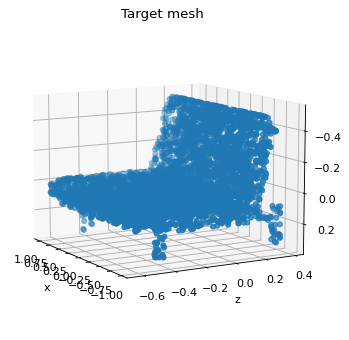

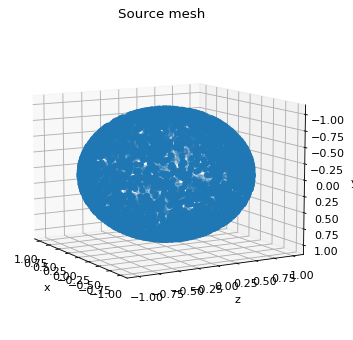

In [23]:
# %matplotlib notebook
plot_pointcloud(trg_mesh, "Target mesh")
plot_pointcloud(src_mesh, "Source mesh")

In [24]:
# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in src_mesh
deform_verts = torch.full(src_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)

In [25]:
# The optimizer
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

  0%|          | 0/2000 [00:00<?, ?it/s]

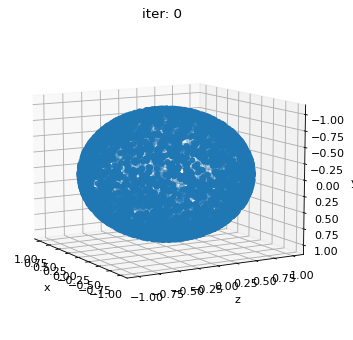

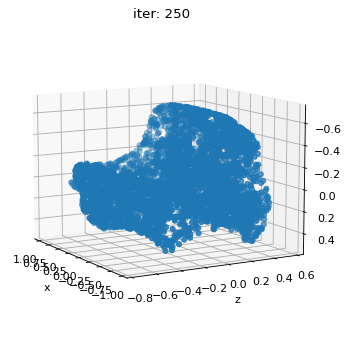

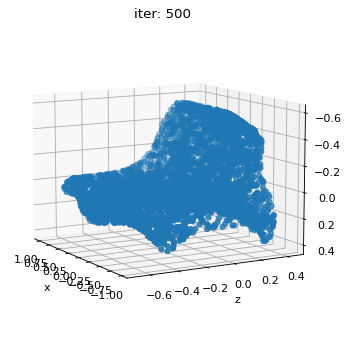

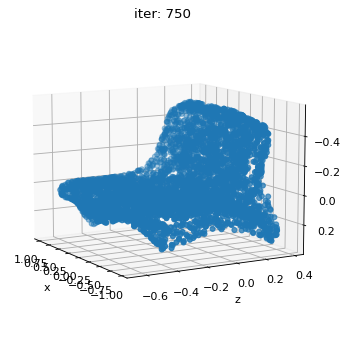

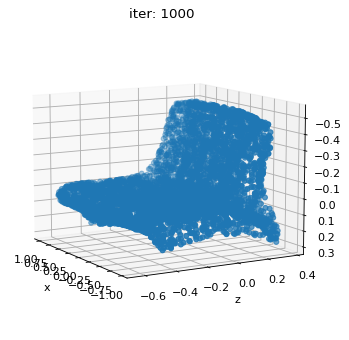

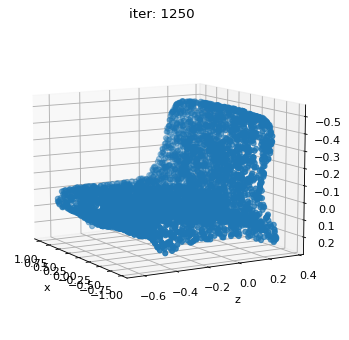

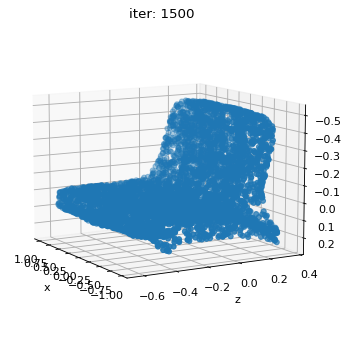

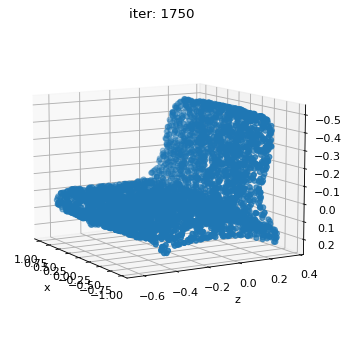

In [26]:
# Number of optimization steps
Niter = 2000
# Weight for the chamfer loss
w_chamfer = 1.0 
# Weight for mesh edge loss
w_edge = 1.0 
# Weight for mesh normal consistency
w_normal = 0.01 
# Weight for mesh laplacian smoothing
w_laplacian = 0.1 
# Plot period for the losses
plot_period = 250
loop = tqdm(range(Niter))

chamfer_losses = []
laplacian_losses = []
edge_losses = []
normal_losses = []

%matplotlib inline

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()
    
    # Deform the mesh
    new_src_mesh = src_mesh.offset_verts(deform_verts)
    
    # We sample 5k points from the surface of each mesh 
    sample_trg = sample_points_from_meshes(trg_mesh, 5000)
    sample_src = sample_points_from_meshes(new_src_mesh, 5000)
    
    # We compare the two sets of pointclouds by computing (a) the chamfer loss
    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)
    
    # and (b) the edge length of the predicted mesh
    loss_edge = mesh_edge_loss(new_src_mesh)
    
    # mesh normal consistency
    loss_normal = mesh_normal_consistency(new_src_mesh)
    
    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")
    
    # Weighted sum of the losses
    loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian
    
    # Print the losses
    loop.set_description('total_loss = %.6f' % loss)
    
    # Save the losses for plotting
    chamfer_losses.append(float(loss_chamfer.detach().cpu()))
    edge_losses.append(float(loss_edge.detach().cpu()))
    normal_losses.append(float(loss_normal.detach().cpu()))
    laplacian_losses.append(float(loss_laplacian.detach().cpu()))
    
    # Plot mesh
    if i % plot_period == 0:
        plot_pointcloud(new_src_mesh, title="iter: %d" % i)
        
    # Optimization step
    loss.backward()
    optimizer.step()

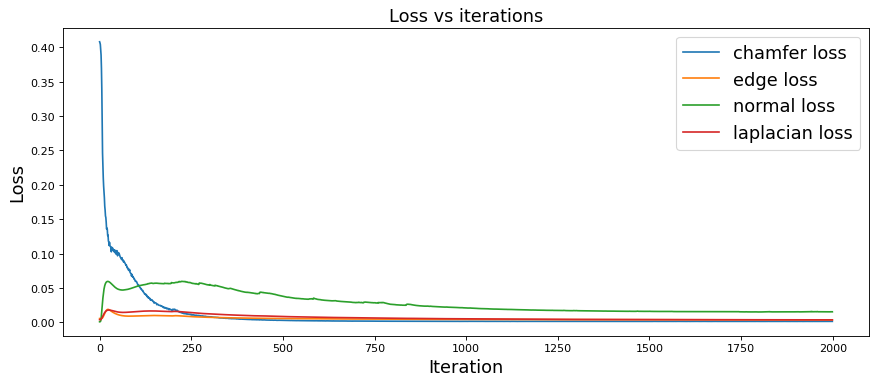

In [27]:
fig = plt.figure(figsize=(13, 5))
ax = fig.gca()
ax.plot(chamfer_losses, label="chamfer loss")
ax.plot(edge_losses, label="edge loss")
ax.plot(normal_losses, label="normal loss")
ax.plot(laplacian_losses, label="laplacian loss")
ax.legend(fontsize="16")
ax.set_xlabel("Iteration", fontsize="16")
ax.set_ylabel("Loss", fontsize="16")
ax.set_title("Loss vs iterations", fontsize="16");

In [ ]:
# Fetch the verts and faces of the final predicted mesh
final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)

# Scale normalize back to the original target size
final_verts = final_verts * scale + center

# Store the predicted mesh using save_obj
final_obj = 'final_model.obj'
save_obj(final_obj, final_verts, final_faces)

In [42]:
import os
import sys
import time
import json
import glob
import torch
import math
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from IPython import display

# Data structures and functions for rendering
from pytorch3d.structures import Volumes
from pytorch3d.renderer import (
    FoVPerspectiveCameras, 
    VolumeRenderer,
    NDCMultinomialRaysampler,
    EmissionAbsorptionRaymarcher
)
from pytorch3d.transforms import so3_exp_map

# obtain the utilized device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

In [44]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/generate_cow_renders.py
from plot_image_grid import image_grid
from generate_cow_renders import generate_cow_renders

--2024-10-02 13:03:15--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: 'plot_image_grid.py'

plot_image_grid.py  100%[===================>]   1.57K  --.-KB/s    in 0s      

2024-10-02 13:03:16 (20.2 MB/s) - 'plot_image_grid.py' saved [1608/1608]

--2024-10-02 13:03:17--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/generate_cow_renders.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request se

In [45]:
target_cameras, target_images, target_silhouettes = generate_cow_renders(num_views=40)
print(f'Generated {len(target_images)} images/silhouettes/cameras.')

--2024-10-02 13:03:29--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.51, 3.162.163.11, 3.162.163.34, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330659 (323K) [text/plain]
Saving to: '/kaggle/working/../data/cow_mesh/cow.obj'

     0K .......... .......... .......... .......... .......... 15%  510K 1s
    50K .......... .......... .......... .......... .......... 30% 9.58M 0s
   100K .......... .......... .......... .......... .......... 46% 1.13M 0s
   150K .......... .......... .......... .......... .......... 61% 21.0M 0s
   200K .......... .......... .......... .......... .......... 77% 26.1M 0s
   250K .......... .......... .......... .......... .......... 92% 8.30M 0s
   300K .......... .......... ..                              100%  592K=0.2s

2024-10-02 13:03:30 (1.62 MB/s) - '/kag

Generated 40 images/silhouettes/cameras.


In [46]:
# render_size describes the size of both sides of the 
# rendered images in pixels. We set this to the same size
# as the target images. I.e. we render at the same
# size as the ground truth images.
render_size = target_images.shape[1]

# Our rendered scene is centered around (0,0,0) 
# and is enclosed inside a bounding box
# whose side is roughly equal to 3.0 (world units).
volume_extent_world = 3.0

# 1) Instantiate the raysampler.
# Here, NDCMultinomialRaysampler generates a rectangular image
# grid of rays whose coordinates follow the PyTorch3D
# coordinate conventions.
# Since we use a volume of size 128^3, we sample n_pts_per_ray=150,
# which roughly corresponds to a one ray-point per voxel.
# We further set the min_depth=0.1 since there is no surface within
# 0.1 units of any camera plane.
raysampler = NDCMultinomialRaysampler(
    image_width=render_size,
    image_height=render_size,
    n_pts_per_ray=150,
    min_depth=0.1,
    max_depth=volume_extent_world,
)


# 2) Instantiate the raymarcher.
# Here, we use the standard EmissionAbsorptionRaymarcher 
# which marches along each ray in order to render
# each ray into a single 3D color vector 
# and an opacity scalar.
raymarcher = EmissionAbsorptionRaymarcher()

# Finally, instantiate the volumetric render
# with the raysampler and raymarcher objects.
renderer = VolumeRenderer(
    raysampler=raysampler, raymarcher=raymarcher,
)

In [47]:
class VolumeModel(torch.nn.Module):
    def __init__(self, renderer, volume_size=[64] * 3, voxel_size=0.1):
        super().__init__()
        # After evaluating torch.sigmoid(self.log_colors), we get 
        # densities close to zero.
        self.log_densities = torch.nn.Parameter(-4.0 * torch.ones(1, *volume_size))
        # After evaluating torch.sigmoid(self.log_colors), we get 
        # a neutral gray color everywhere.
        self.log_colors = torch.nn.Parameter(torch.zeros(3, *volume_size))
        self._voxel_size = voxel_size
        # Store the renderer module as well.
        self._renderer = renderer
        
    def forward(self, cameras):
        batch_size = cameras.R.shape[0]

        # Convert the log-space values to the densities/colors
        densities = torch.sigmoid(self.log_densities)
        colors = torch.sigmoid(self.log_colors)
        
        # Instantiate the Volumes object, making sure
        # the densities and colors are correctly
        # expanded batch_size-times.
        volumes = Volumes(
            densities = densities[None].expand(
                batch_size, *self.log_densities.shape),
            features = colors[None].expand(
                batch_size, *self.log_colors.shape),
            voxel_size=self._voxel_size,
        )
        
        # Given cameras and volumes, run the renderer
        # and return only the first output value 
        # (the 2nd output is a representation of the sampled
        # rays which can be omitted for our purpose).
        return self._renderer(cameras=cameras, volumes=volumes)[0]
    
# A helper function for evaluating the smooth L1 (huber) loss
# between the rendered silhouettes and colors.
def huber(x, y, scaling=0.1):
    diff_sq = (x - y) ** 2
    loss = ((1 + diff_sq / (scaling**2)).clamp(1e-4).sqrt() - 1) * float(scaling)
    return loss

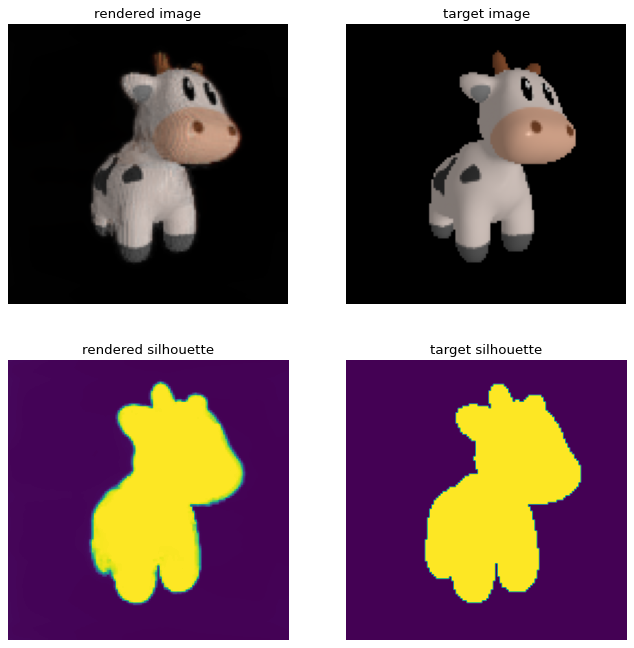

Iteration 00290: color_err = 3.86e-03 mask_err = 9.64e-03


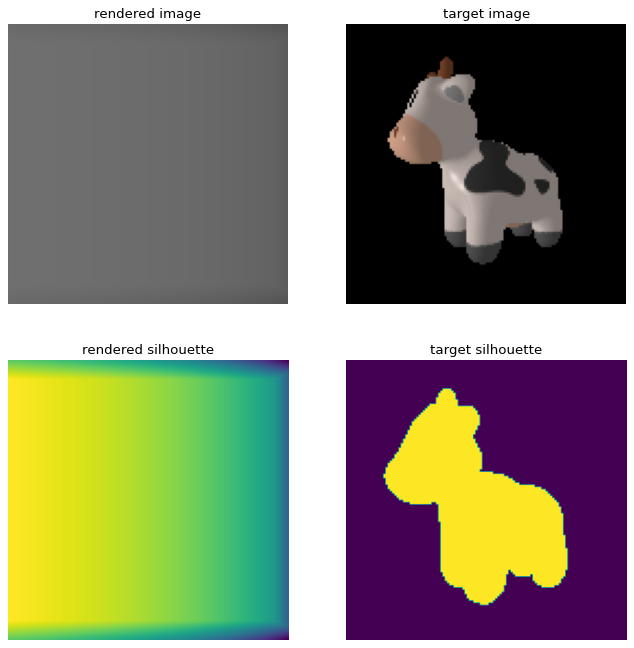

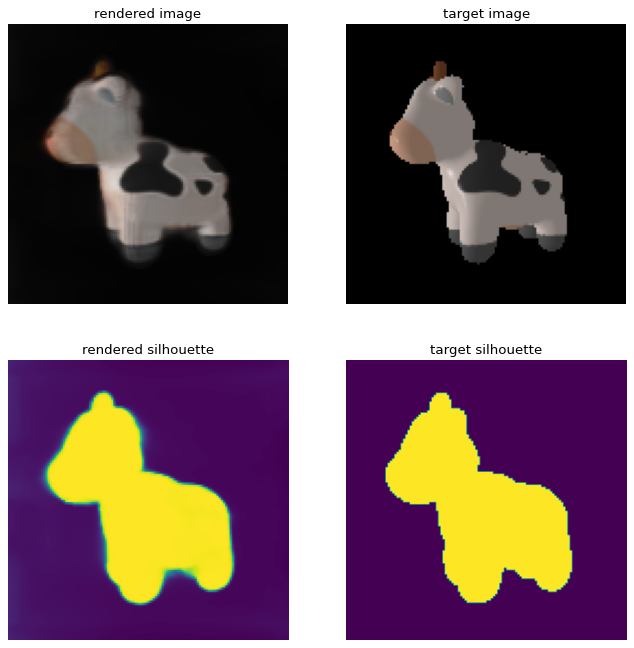

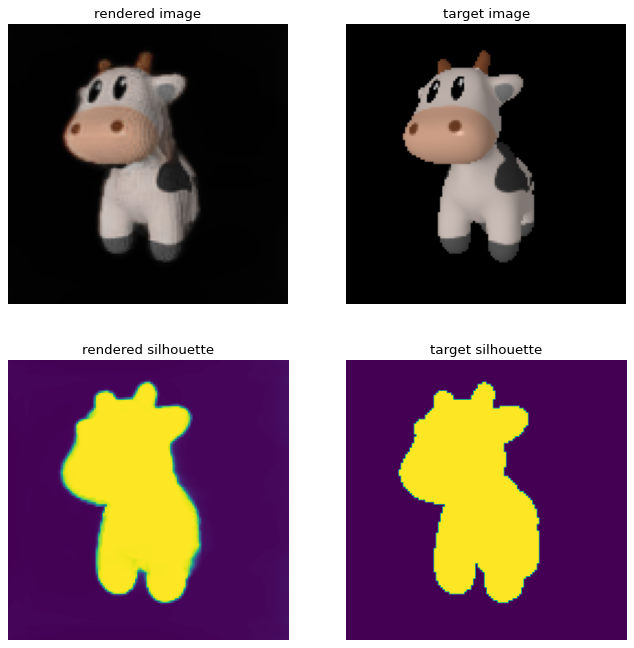

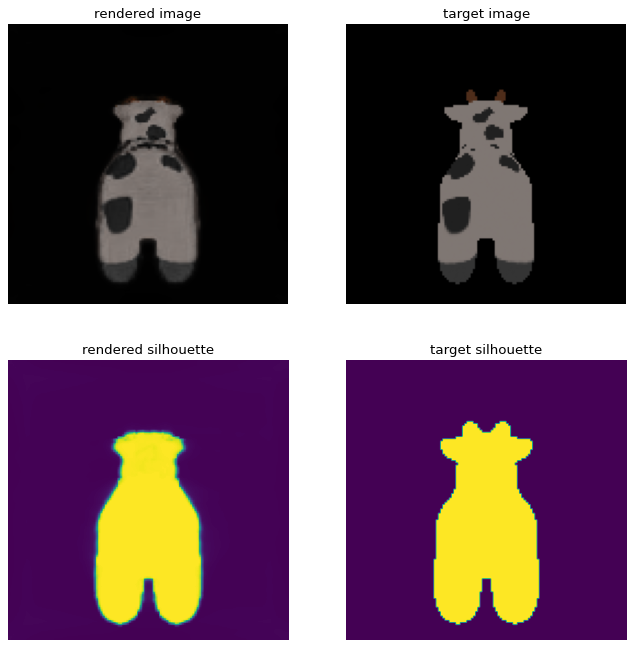

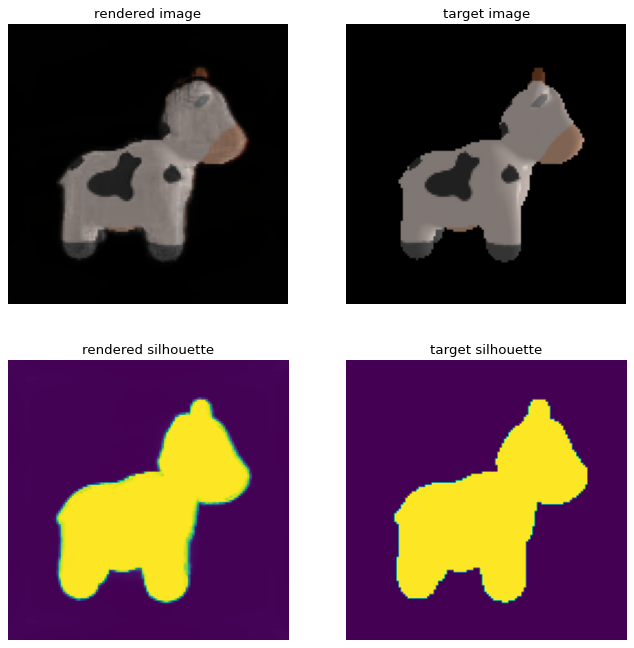

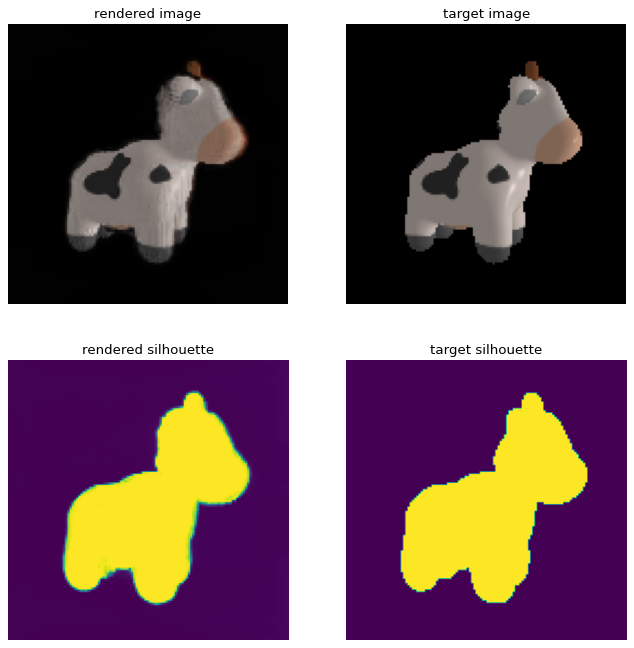

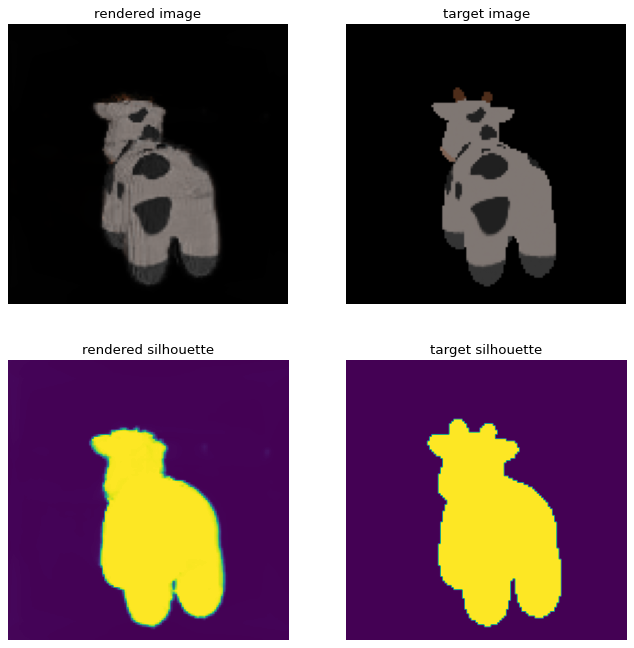

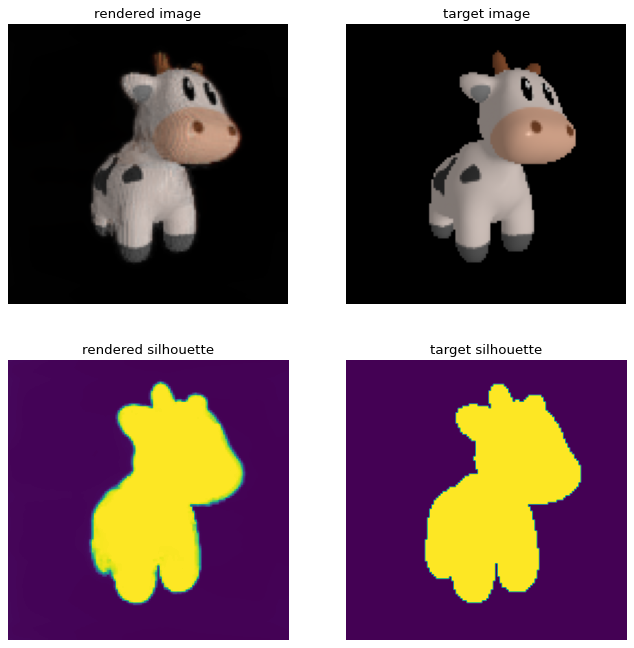

In [48]:
# First move all relevant variables to the correct device.
target_cameras = target_cameras.to(device)
target_images = target_images.to(device)
target_silhouettes = target_silhouettes.to(device)

# Instantiate the volumetric model.
# We use a cubical volume with the size of 
# one side = 128. The size of each voxel of the volume 
# is set to volume_extent_world / volume_size s.t. the
# volume represents the space enclosed in a 3D bounding box
# centered at (0, 0, 0) with the size of each side equal to 3.
volume_size = 128
volume_model = VolumeModel(
    renderer,
    volume_size=[volume_size] * 3, 
    voxel_size = volume_extent_world / volume_size,
).to(device)

# Instantiate the Adam optimizer. We set its master learning rate to 0.1.
lr = 0.1
optimizer = torch.optim.Adam(volume_model.parameters(), lr=lr)

# We do 300 Adam iterations and sample 10 random images in each minibatch.
batch_size = 10
n_iter = 300
for iteration in range(n_iter):

    # In case we reached the last 75% of iterations,
    # decrease the learning rate of the optimizer 10-fold.
    if iteration == round(n_iter * 0.75):
        print('Decreasing LR 10-fold ...')
        optimizer = torch.optim.Adam(
            volume_model.parameters(), lr=lr * 0.1
        )
    
    # Zero the optimizer gradient.
    optimizer.zero_grad()
    
    # Sample random batch indices.
    batch_idx = torch.randperm(len(target_cameras))[:batch_size]
    
    # Sample the minibatch of cameras.
    batch_cameras = FoVPerspectiveCameras(
        R = target_cameras.R[batch_idx], 
        T = target_cameras.T[batch_idx], 
        znear = target_cameras.znear[batch_idx],
        zfar = target_cameras.zfar[batch_idx],
        aspect_ratio = target_cameras.aspect_ratio[batch_idx],
        fov = target_cameras.fov[batch_idx],
        device = device,
    )
    
    # Evaluate the volumetric model.
    rendered_images, rendered_silhouettes = volume_model(
        batch_cameras
    ).split([3, 1], dim=-1)
    
    # Compute the silhouette error as the mean huber
    # loss between the predicted masks and the
    # target silhouettes.
    sil_err = huber(
        rendered_silhouettes[..., 0], target_silhouettes[batch_idx],
    ).abs().mean()

    # Compute the color error as the mean huber
    # loss between the rendered colors and the
    # target ground truth images.
    color_err = huber(
        rendered_images, target_images[batch_idx],
    ).abs().mean()
    
    # The optimization loss is a simple
    # sum of the color and silhouette errors.
    loss = color_err + sil_err 
    
    # Print the current values of the losses.
    if iteration % 10 == 0:
        print(
            f'Iteration {iteration:05d}:'
            + f' color_err = {float(color_err):1.2e}'
            + f' mask_err = {float(sil_err):1.2e}'
        )
    
    # Take the optimization step.
    loss.backward()
    optimizer.step()
    
    # Visualize the renders every 40 iterations.
    if iteration % 40 == 0:
        # Visualize only a single randomly selected element of the batch.
        im_show_idx = int(torch.randint(low=0, high=batch_size, size=(1,)))
        fig, ax = plt.subplots(2, 2, figsize=(10, 10))
        ax = ax.ravel()
        clamp_and_detach = lambda x: x.clamp(0.0, 1.0).cpu().detach().numpy()
        ax[0].imshow(clamp_and_detach(rendered_images[im_show_idx]))
        ax[1].imshow(clamp_and_detach(target_images[batch_idx[im_show_idx], ..., :3]))
        ax[2].imshow(clamp_and_detach(rendered_silhouettes[im_show_idx, ..., 0]))
        ax[3].imshow(clamp_and_detach(target_silhouettes[batch_idx[im_show_idx]]))
        for ax_, title_ in zip(
            ax, 
            ("rendered image", "target image", "rendered silhouette", "target silhouette")
        ):
            ax_.grid("off")
            ax_.axis("off")
            ax_.set_title(title_)
        fig.canvas.draw(); fig.show()
        display.clear_output(wait=True)
        display.display(fig)

Generating rotating volume ...


  0%|          | 0/28 [00:00<?, ?it/s]

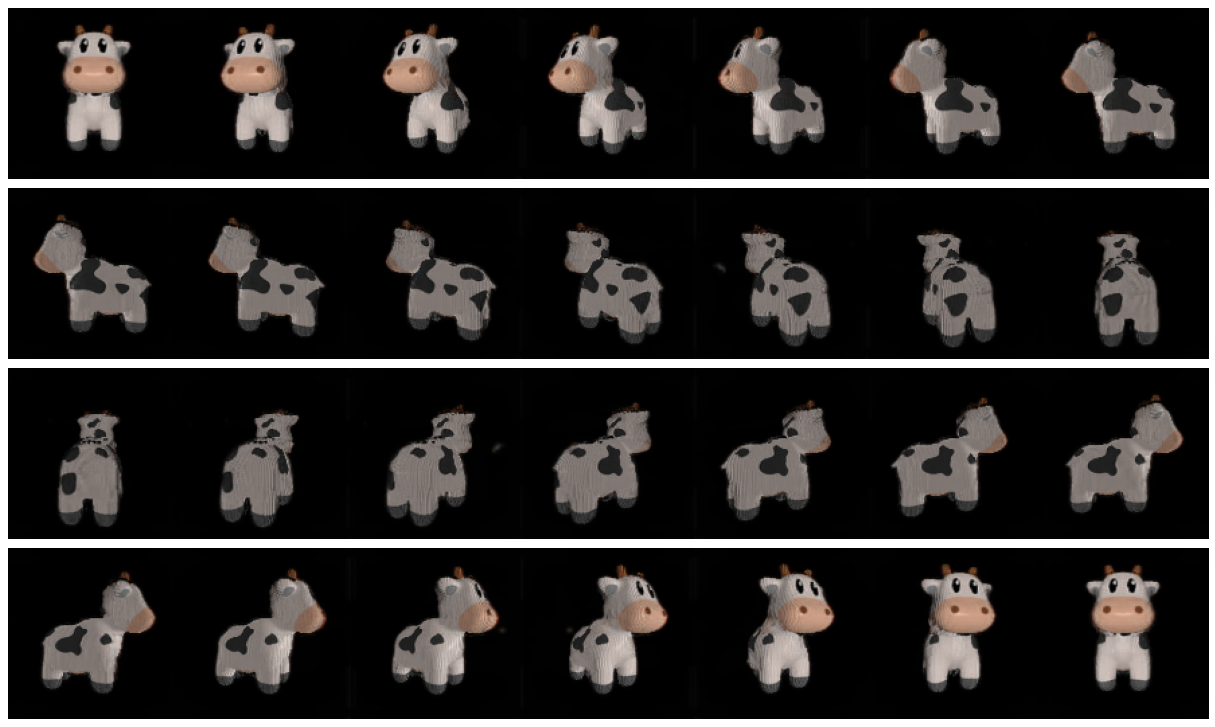

In [49]:
def generate_rotating_volume(volume_model, n_frames = 50):
    logRs = torch.zeros(n_frames, 3, device=device)
    logRs[:, 1] = torch.linspace(0.0, 2.0 * 3.14, n_frames, device=device)
    Rs = so3_exp_map(logRs)
    Ts = torch.zeros(n_frames, 3, device=device)
    Ts[:, 2] = 2.7
    frames = []
    print('Generating rotating volume ...')
    for R, T in zip(tqdm(Rs), Ts):
        camera = FoVPerspectiveCameras(
            R=R[None], 
            T=T[None], 
            znear = target_cameras.znear[0],
            zfar = target_cameras.zfar[0],
            aspect_ratio = target_cameras.aspect_ratio[0],
            fov = target_cameras.fov[0],
            device=device,
        )
        frames.append(volume_model(camera)[..., :3].clamp(0.0, 1.0))
    return torch.cat(frames)
    
with torch.no_grad():
    rotating_volume_frames = generate_rotating_volume(volume_model, n_frames=7*4)

image_grid(rotating_volume_frames.clamp(0., 1.).cpu().numpy(), rows=4, cols=7, rgb=True, fill=True)
plt.show()